---
title: "군집화"
author: "Sungil_Park"
date: "2024/04/24"
description: "하수구 위치, 표고(지형) 데이터를 사용한 군집화"
categories: [Python, ipynb]
editor_options: 
  chunk_output_type: inline
---

## 1. 하수구 위경도만으로 군집화

In [2]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
import folium
from folium import CircleMarker
from shapely.geometry import Point

data_raw = pd.read_csv("/home/sungil/Income_pred_Dacon/PersonalProj/완_하수구_위치_정보.csv")
data = data_raw[["lat","lon"]].copy()

geometry = [Point(lon, lat) for lon, lat in zip(data_raw['lon'], data_raw['lat'])]

data_raw = gpd.GeoDataFrame(data_raw, geometry=geometry)

data_raw.crs= 'EPSG:4326'
data_raw.head()

,수위계번호,수위계 설치지점,박스높이(m),lat,lon,geometry
0,23-0001,강남구 압구정로20길 6앞 맨홀<심덕빌딩(최용섭피부과)앞~백상빌딩간 횡단보도내>,2.0,37.524714,127.024854,POINT (127.02485 37.52471)
1,23-0002,"강남구 압구정로128앞 맨홀(신사동주민센터앞 횡단보도내, 현대고 서측정문앞)",2.0,37.524144,127.022466,POINT (127.02247 37.52414)
2,23-0003,"강남구 남부순환로2947앞(대원빌딩앞 횡단보도내, 대치역사거리)",2.5,37.494475,127.063235,POINT (127.06324 37.49448)
3,23-0004,"강남구 삼성로212앞 맨홀(은마아파트1동~미도아파트208동간,중안차로 안전지대내)",2.5,37.496052,127.068492,POINT (127.06849 37.49605)
4,23-0005,테헤란로435앞 맨홀(대종빌딩~삼영빌딩간 횡단보도앞 테헤란로측),2.5,37.506400,127.055012,POINT (127.05501 37.50640)


In [2]:
kmeans = KMeans(n_clusters=4, random_state=42,n_init=10)
kmeans.fit(data)
labels = kmeans.predict(data)
centroids = kmeans.cluster_centers_
def get_cluster_color(cluster_idx):
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'pink', 'cyan', 'magenta', 'gray']
    return colors[cluster_idx % len(colors)]

M = folium.Map(location=[37.50452, 127.055],
                              zoom_start=13,tiles="Cartodb Positron")

for idx, row in data_raw.iterrows():
    cluster_idx = labels[idx]  # 데이터 포인트의 군집 인덱스
    color = get_cluster_color(cluster_idx) 

    CircleMarker(location=[row['lat'], row['lon']],
                 radius=3,
                 tooltip=row["수위계번호"],  # 툴팁에 군집 인덱스 표시
                 color=color,
                 fill=True,
                 fill_opacity=1,
                 opacity=1
                ).add_to(M)

# Plot Centroids
for centroid in centroids:
    folium.Marker(location=[centroid[0], centroid[1]],
                  icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(M)

M

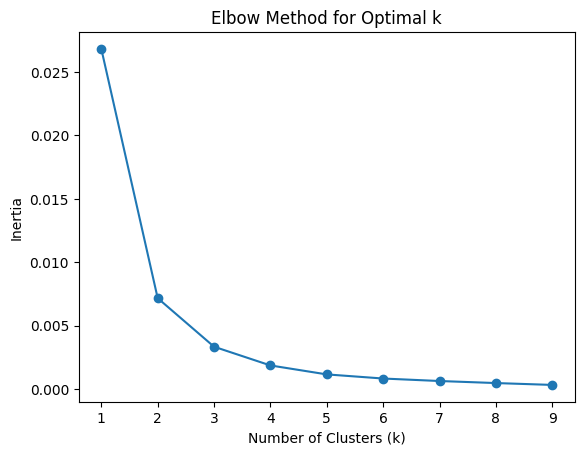

In [3]:
import matplotlib.pyplot as plt
k_range = range(1, 10)
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.show()

### 군집수 : 3

## 표고 데이터 병합하기

In [3]:
import geopandas as gpd
pyogo = gpd.read_file("~/rawdata/gyeongsa/표고 5000/N3P_F002.shp")
pyogo.drop(["UFID","NUME","SCLS","FMTA"], axis=1, inplace=True)	

if pyogo.crs is None:
    pyogo.set_crs(epsg = 5179, inplace = True)
    
print("Original CRS set to:", pyogo.crs)

pyogo = pyogo.to_crs(epsg=4326)
print("Transformed CRS:", pyogo.crs)
pyogo.head()

Original CRS set to: EPSG:5174
Transformed CRS: EPSG:4326


,HEIGHT,geometry
0,213.080002,POINT (126.92718 37.41191)
1,68.430000,POINT (127.08504 37.41257)
2,150.309998,POINT (127.07865 37.41256)
3,39.209999,POINT (126.90436 37.41182)
4,342.640015,POINT (127.04173 37.41244)


In [5]:
import random
import folium
from folium import  Polygon

data_raw_utm = data_raw.to_crs('EPSG:32652')  # 예시로 UTM Zone 52N 좌표계를 사용합니다.

# 버퍼 추가
buffer_radius = 300
data_raw_utm['geometry'] = data_raw_utm['geometry'].buffer(buffer_radius)

data_raw_buffer = data_raw_utm.to_crs(data_raw.crs)
# data_raw_buffer.head()

M = folium.Map(location=[37.50452, 127.04899], 
               zoom_start=13,tiles="Cartodb Positron")

folium.GeoJson(data_raw_buffer, 
               name="geojson").add_to(M)

M

In [6]:
joined_gdf = gpd.sjoin(pyogo,data_raw_buffer, predicate="within")
joined_gdf.drop(["수위계 설치지점"], axis=1, inplace=True)
joined_gdf.head()

,HEIGHT,geometry,index_right,수위계번호,박스높이(m),lat,lon
5850,28.719999,POINT (127.09539 37.48277),20,23-0021,2.6,37.484353,127.094982
7888,23.200001,POINT (127.09403 37.48400),20,23-0021,2.6,37.484353,127.094982
8314,24.650000,POINT (127.09367 37.48376),20,23-0021,2.6,37.484353,127.094982
8885,31.600000,POINT (127.09728 37.48350),20,23-0021,2.6,37.484353,127.094982
8970,22.840000,POINT (127.09450 37.48385),20,23-0021,2.6,37.484353,127.094982


In [7]:
joined_gdf.dtypes

HEIGHT          float64
geometry       geometry
index_right       int64
수위계번호            object
박스높이(m)         float64
lat             float64
lon             float64
dtype: object

In [8]:
joined_gdf_2 = joined_gdf.groupby('수위계번호').mean().reset_index()
joined_gdf_2.head()

/tmp/ipykernel_19905/1738235292.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  joined_gdf_2 = joined_gdf.groupby('수위계번호').mean().reset_index()


,수위계번호,HEIGHT,index_right,박스높이(m),lat,lon
0,22-0007,16.685000,21.0,2.0,37.494394,127.028372
1,22-0010,18.601481,22.0,3.0,37.498114,127.026919
2,22-0011,18.190000,23.0,2.5,37.496433,127.028082
3,22-0012,16.471220,24.0,3.0,37.498106,127.022192
4,22-0013,22.450952,25.0,4.4,37.500400,127.018828


In [9]:
from folium import CircleMarker

M = folium.Map(location=[37.50452, 127.04899], 
               zoom_start=13,tiles="Cartodb Positron")

for idx,row in joined_gdf_2.iterrows():
    CircleMarker(location=[row["lat"],row["lon"]],
                 radius=3,
                 tooltip=row["HEIGHT"],  # 툴팁에 군집 인덱스 표시
                 fill=True,
                 fill_opacity=1,
                 opacity=1
                ).add_to(M)


M

In [10]:
M = folium.Map(location=[37.50452, 127.04899], 
               zoom_start=13,tiles="Cartodb Positron")

folium.GeoJson(data_raw_buffer, 
               name="geojson").add_to(M)

folium.GeoJson(joined_gdf, 
               name="geojson").add_to(M)

M

----

## 표고 포함 군집화

In [32]:
joined_gdf_3 = joined_gdf_2.loc[:,["HEIGHT","lat","lon"]]
joined_gdf_3.head()

,HEIGHT,lat,lon
0,16.685000,37.494394,127.028372
1,18.601481,37.498114,127.026919
2,18.190000,37.496433,127.028082
3,16.471220,37.498106,127.022192
4,22.450952,37.500400,127.018828


In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(joined_gdf_3)
scaled_df = pd.DataFrame(scaled_data, columns=joined_gdf_3.columns)

In [34]:
kmeans = KMeans(n_clusters=4, random_state=42,n_init=10)
kmeans.fit(scaled_df)
labels = kmeans.predict(scaled_df)
centroids = kmeans.cluster_centers_

joined_gdf_3["label"] = labels
joined_gdf_3

,HEIGHT,lat,lon,label
0,16.685000,37.494394,127.028372,3
1,18.601481,37.498114,127.026919,3
2,18.190000,37.496433,127.028082,3
3,16.471220,37.498106,127.022192,3
4,22.450952,37.500400,127.018828,3
5,16.685000,37.494399,127.028329,3
6,15.413061,37.524714,127.024854,0
7,14.988200,37.524144,127.022466,0
8,13.772666,37.494475,127.063235,1
9,14.181333,37.496052,127.068492,1


### k = 4

In [35]:
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'black'}

M = folium.Map(location=[37.50452, 127.055],
                              zoom_start=13,tiles="Cartodb Positron")

for idx, row in joined_gdf_3.iterrows():
    cluster_idx = labels[idx]  # 데이터 포인트의 군집 인덱스
    color = get_cluster_color(cluster_idx) 

    CircleMarker(location=[row['lat'], row['lon']],
                 radius=3,
                 tooltip=[row["HEIGHT"]],  # 툴팁에 군집 인덱스 표시
                 color=color_dict[row["label"]],
                 fill=True,
                 fill_opacity=1,
                 opacity=1
                ).add_to(M)

# Plot Centroids
for centroid in centroids:
    folium.Marker(location=[centroid[0], centroid[1]],
                  icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(M)

M

### k = 3

In [37]:
kmeans = KMeans(n_clusters=3, random_state=42,n_init=10)
kmeans.fit(scaled_df)
labels = kmeans.predict(scaled_df)
centroids = kmeans.cluster_centers_
def get_cluster_color(cluster_idx):
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'pink', 'cyan', 'magenta', 'gray']
    return colors[cluster_idx % len(colors)]

M = folium.Map(location=[37.50452, 127.055],
                              zoom_start=13,tiles="Cartodb Positron")

for idx, row in joined_gdf_2.iterrows():
    cluster_idx = labels[idx]  # 데이터 포인트의 군집 인덱스
    color = get_cluster_color(cluster_idx) 

    CircleMarker(location=[row['lat'], row['lon']],
                 radius=3,
                 tooltip=[row["HEIGHT"]],  # 툴팁에 군집 인덱스 표시
                 color=color,
                 fill=True,
                 fill_opacity=1,
                 opacity=1
                ).add_to(M)

# Plot Centroids
for centroid in centroids:
    folium.Marker(location=[centroid[0], centroid[1]],
                  icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(M)

M

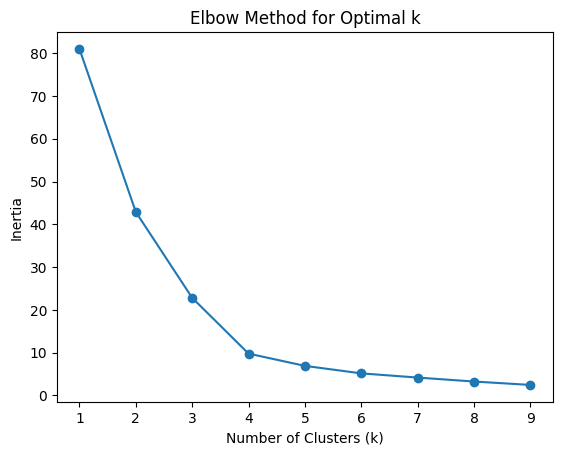

In [38]:
import matplotlib.pyplot as plt
k_range = range(1, 10)
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.show()

----
## 박스높이 포함 군집화

In [39]:
joined_gdf_4 = joined_gdf_2.loc[:,["HEIGHT","lat","lon","박스높이(m)"]]
joined_gdf_4.head()

,HEIGHT,lat,lon,박스높이(m)
0,16.685000,37.494394,127.028372,2.0
1,18.601481,37.498114,127.026919,3.0
2,18.190000,37.496433,127.028082,2.5
3,16.471220,37.498106,127.022192,3.0
4,22.450952,37.500400,127.018828,4.4


In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data_2 = scaler.fit_transform(joined_gdf_4)
scaled_df_2 = pd.DataFrame(scaled_data_2, columns=joined_gdf_4.columns)

### k = 3

In [44]:
kmeans = KMeans(n_clusters=3, random_state=42,n_init=10)
kmeans.fit(scaled_df_2)
labels = kmeans.predict(scaled_df_2)
centroids = kmeans.cluster_centers_

joined_gdf_4["label"] = labels
joined_gdf_4
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'black'}

M = folium.Map(location=[37.50452, 127.055],
                              zoom_start=13,tiles="Cartodb Positron")

for idx, row in joined_gdf_4.iterrows():
    cluster_idx = labels[idx]  # 데이터 포인트의 군집 인덱스
    color = get_cluster_color(cluster_idx) 

    CircleMarker(location=[row['lat'], row['lon']],
                 radius=3,
                 tooltip=[row["HEIGHT"]],  # 툴팁에 군집 인덱스 표시
                 color=color_dict[row["label"]],
                 fill=True,
                 fill_opacity=1,
                 opacity=1
                ).add_to(M)

# Plot Centroids
for centroid in centroids:
    folium.Marker(location=[centroid[0], centroid[1]],
                  icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(M)

M

### k = 4

In [45]:
kmeans = KMeans(n_clusters=4, random_state=42,n_init=10)
kmeans.fit(scaled_df_2)
labels = kmeans.predict(scaled_df_2)
centroids = kmeans.cluster_centers_

joined_gdf_4["label"] = labels
joined_gdf_4
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'black'}

M = folium.Map(location=[37.50452, 127.055],
                              zoom_start=13,tiles="Cartodb Positron")

for idx, row in joined_gdf_4.iterrows():
    cluster_idx = labels[idx]  # 데이터 포인트의 군집 인덱스
    color = get_cluster_color(cluster_idx) 

    CircleMarker(location=[row['lat'], row['lon']],
                 radius=3,
                 tooltip=[row["HEIGHT"]],  # 툴팁에 군집 인덱스 표시
                 color=color_dict[row["label"]],
                 fill=True,
                 fill_opacity=1,
                 opacity=1
                ).add_to(M)

# Plot Centroids
for centroid in centroids:
    folium.Marker(location=[centroid[0], centroid[1]],
                  icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(M)

M

### k = 5

In [47]:
kmeans = KMeans(n_clusters=5, random_state=42,n_init=10)
kmeans.fit(scaled_df_2)
labels = kmeans.predict(scaled_df_2)
centroids = kmeans.cluster_centers_

joined_gdf_4["label"] = labels
joined_gdf_4
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'black', 4: 'yellow'}

M = folium.Map(location=[37.50452, 127.055],
                              zoom_start=13,tiles="Cartodb Positron")

for idx, row in joined_gdf_4.iterrows():
    cluster_idx = labels[idx]  # 데이터 포인트의 군집 인덱스
    color = get_cluster_color(cluster_idx) 

    CircleMarker(location=[row['lat'], row['lon']],
                 radius=3,
                 tooltip=[row["HEIGHT"]],  # 툴팁에 군집 인덱스 표시
                 color=color_dict[row["label"]],
                 fill=True,
                 fill_opacity=1,
                 opacity=1
                ).add_to(M)

# Plot Centroids
for centroid in centroids:
    folium.Marker(location=[centroid[0], centroid[1]],
                  icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(M)

M

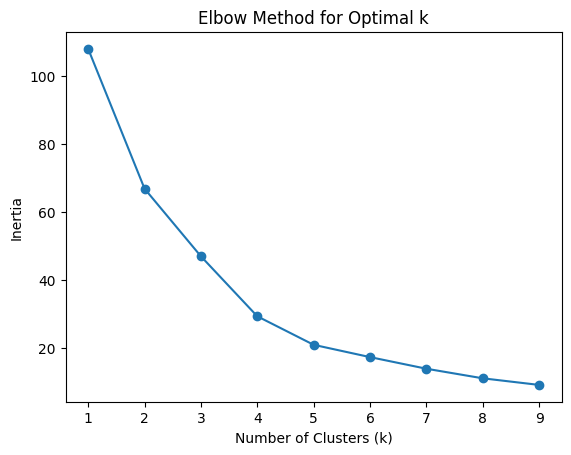

In [49]:
import matplotlib.pyplot as plt
k_range = range(1, 10)
inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df_2)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.show()